---
# ROVER PROJECT TEST NOTEBOOK
---

In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

---
# Imports
---

In [2]:

%matplotlib inline

# Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
#%matplotlib qt 

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

from IPython.display import HTML

import cv2 # For perspective transform
import glob  # For reading in a list of images from a folder

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Import pandas and read in csv file as a dataframe
import pandas as pd

import scipy.misc # For saving images as needed

# Example Usage:
# scipy.misc.imsave('../output/warped_example.jpg', warped)

---
# Preload Paths and Images 
---

In [3]:
WORLD_SIZE, SCALE = 200, 30 

path = '../dataset/IMG/*'
img_list = glob.glob(path)

grid1_path = '../calibration_images/example_grid1.jpg'
rock1_path = '../calibration_images/example_rock1.jpg'

grid2_path = '../calibration_images/example_grid2.jpg'
rock2_path = '../calibration_images/example_rock2.jpg'

df = pd.read_csv('../dataset/robot_log.csv', delimiter=';', decimal='.')
data_img_paths = df["Path"].tolist() # list of image pathnames

data_xs = df["X_Position"].values
data_ys = df["Y_Position"].values
data_yaws = df["Yaw"].values

# Read in ground truth map and create a 3-channel image with it
ground_truth_bin = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_ys, ground_truth_xs = ground_truth_bin.nonzero()
ground_truth_img = np.zeros((200, 200, 3))
ground_truth_img[ground_truth_ys, ground_truth_xs, :] = (0, 1, 0) #green

grid1_img = mpimg.imread(grid1_path)
rock1_img = mpimg.imread(rock1_path)
grid2_img = mpimg.imread(grid2_path)
rock2_img = mpimg.imread(rock2_path)
img = mpimg.imread(img_list[3572])
#NOTE: img2 to randomly define later

# Define pathname to save the output video of analysis
output_path = '../output/test_mapping.mp4'

---
# Quick Look at the Data
---

3572


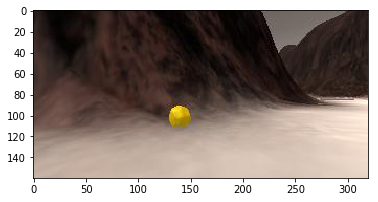

In [4]:
i = 3572
print(3572)
plt.imshow(img)

2336


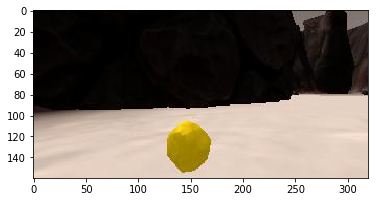

In [5]:

i = np.random.randint(0, len(img_list) - 1)
print(i)

img2 = mpimg.imread(img_list[i])
plt.imshow(img2)

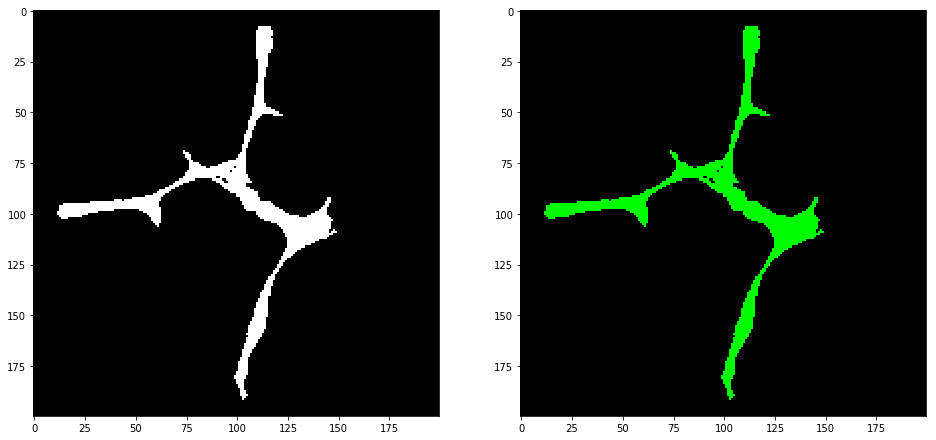

In [6]:
# ground truth map
fig = plt.figure(figsize=(16, 10))

plt.subplot(121)
plt.imshow(ground_truth_bin * 255, cmap = 'gray')

plt.subplot(122)
plt.imshow(ground_truth_img) #range 0.0 - 1.0


In [7]:
print("Example yaws:")
print(data_yaws[1])
print(data_yaws[100])
print(data_yaws[1000])
print()

print("Example x positions:")
print(data_xs[1])
print(data_xs[100])
print(data_xs[1000])
print()

print("Example y positions:")
print(data_ys[1])
print(data_ys[100])
print(data_ys[1000])
print()

print("Example image paths:")
print(data_img_paths[1])
print(data_img_paths[100])
print(data_img_paths[1000])
print()

Example yaws:
56.82556
20.52891
288.063

Example x positions:
99.66999
105.778
101.4444

Example y positions:
85.58897
88.44891
179.476

Example image paths:
/Users/mithisevilla/Desktop/self-driving/RND-term-1/rover/dataset/IMG/robocam_2017_06_08_04_32_59_513.jpg
/Users/mithisevilla/Desktop/self-driving/RND-term-1/rover/dataset/IMG/robocam_2017_06_08_04_33_06_113.jpg
/Users/mithisevilla/Desktop/self-driving/RND-term-1/rover/dataset/IMG/robocam_2017_06_08_04_34_06_116.jpg



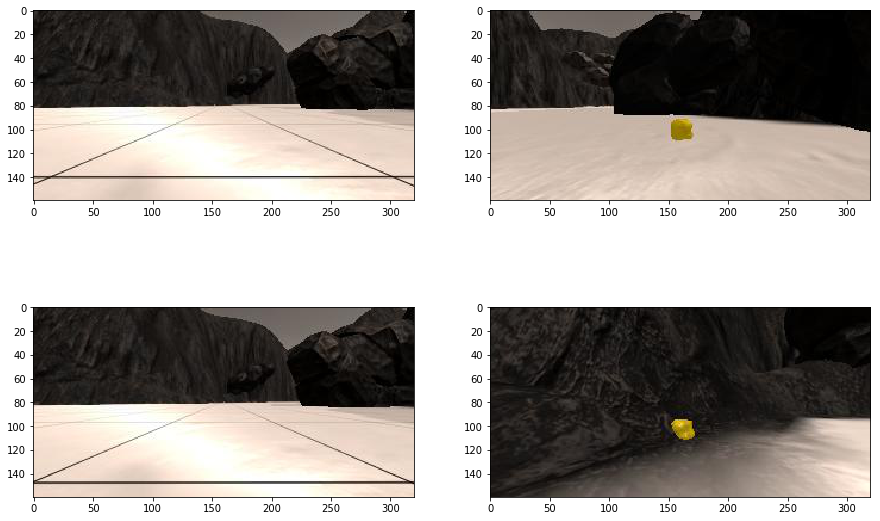

In [8]:
# calibration images
fig = plt.figure(figsize=(15,10))

plt.subplot(221)
plt.imshow(grid1_img)
plt.subplot(222)
plt.imshow(rock1_img)

plt.subplot(223)
plt.imshow(grid2_img)
plt.subplot(224)
plt.imshow(rock2_img)

---
# Helper Plotting Functions
---

In [9]:
def plot_two_images(img1, img2):
  
  fig = plt.figure(figsize=(15, 10))

  plt.subplot(121)
  plt.imshow(img1)
    
  plt.subplot(122)
  plt.imshow(img2)

In [10]:
def plot_three_images(img1, img2, img3):
    
  fig = plt.figure(figsize = (20, 3))
  
  plt.subplot(131)
  plt.imshow(img1)
  
  plt.subplot(132)
  plt.imshow(img2)
  
  plt.subplot(133)
  plt.imshow(img3)

In [11]:
def plot_four_images(img1, img2, img3, img4):
    
  fig = plt.figure(figsize = (20, 3))
  
  plt.subplot(141)
  plt.imshow(img1)
  
  plt.subplot(142)
  plt.imshow(img2)
  
  plt.subplot(143)
  plt.imshow(img3)

  plt.subplot(144)
  plt.imshow(img4)

---
# FUNCTION: `transform_perspective()`
---
- Returns an image `warped_img` by performing a perspective transform to an image `image` given four source points and corresponding destination points

In [12]:
def transform_perspective(img, src, dst):

  transform_matrix = cv2.getPerspectiveTransform(src, dst)
  dimensions = (img.shape[1], img.shape[0]) # keep same size as input image
  warped_img = cv2.warpPerspective(img, transform_matrix, dimensions)     
    
  return warped_img

---
# Source and Destination Points
---
- Define calibration box in source (actual) and destination (desired) coordinates
- These source and destination points are defined to warp the image to a grid where each 10x10 pixel square represents 1 square meter
- The destination box will be `2*dest_size` on each side
- Set a bottom offset to account for the fact that the bottom of the image is not the position of the rover but a bit in front of it
- This is just a rough guess

In [13]:
dest_size, bottom_offset = 5, 6
source_points = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])

h, w = img.shape[0], img.shape[1]
p1, p2 = w / 2 - dest_size, w / 2 + dest_size
p3, p4 = h - bottom_offset, h - 2 * dest_size - bottom_offset

destination_points = np.float32([
    [p1, p3], [p2, p3], [p2, p4], [p1, p4],
    ])

---
# TEST: `transform_perspective()` 
---
- And the source and destination points

In [14]:
warped_img = transform_perspective(img, source_points, destination_points)
warped_img2 = transform_perspective(img2, source_points, destination_points)

warped_grid1_img = transform_perspective(grid1_img, source_points, destination_points)
warped_rock1_img = transform_perspective(rock1_img, source_points, destination_points)
warped_grid2_img = transform_perspective(grid1_img, source_points, destination_points)
warped_rock2_img = transform_perspective(rock1_img, source_points, destination_points)

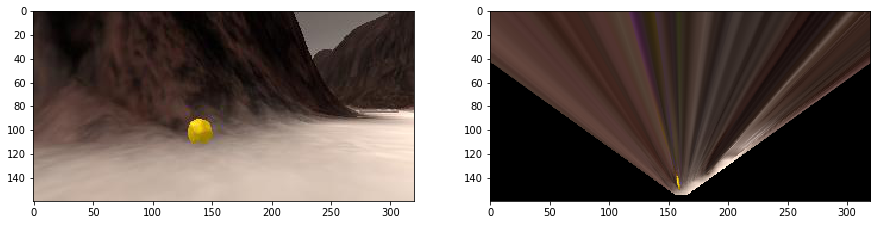

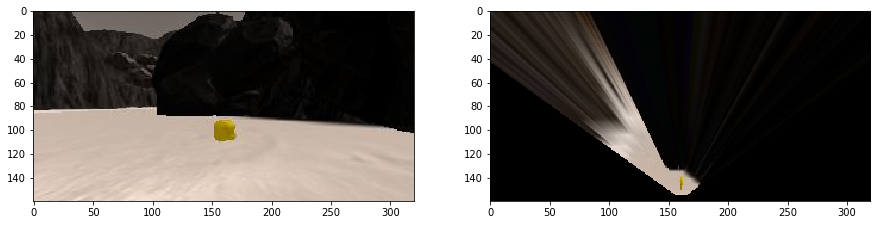

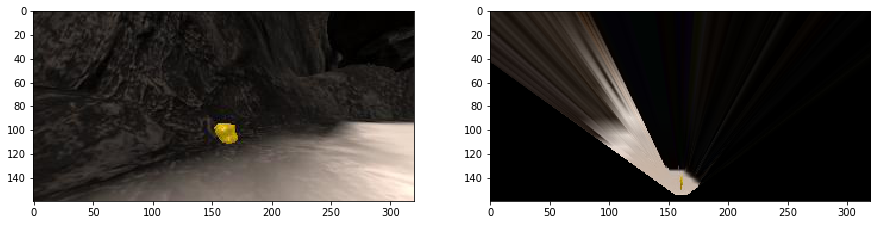

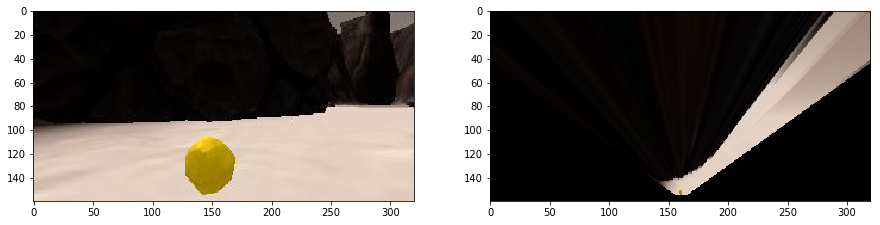

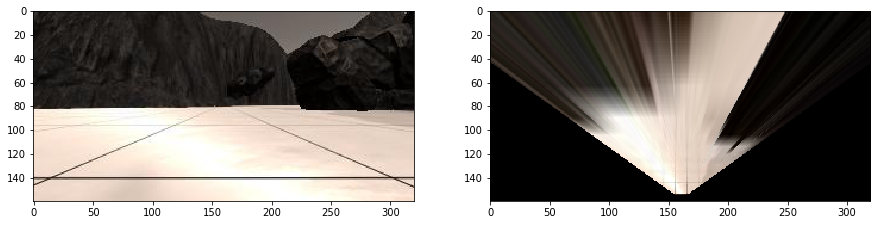

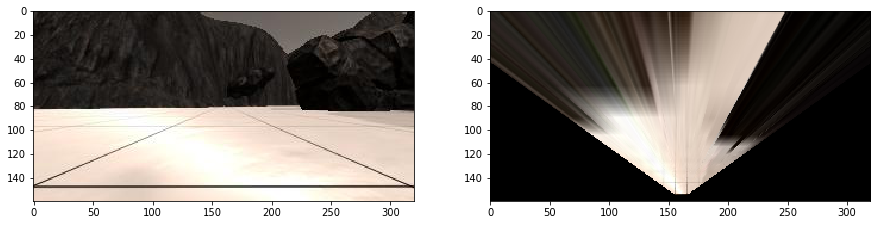

In [15]:
plot_two_images(img, warped_img)
plot_two_images(rock1_img, warped_rock1_img)
plot_two_images(rock2_img, warped_rock2_img)

plot_two_images(img2, warped_img2)
plot_two_images(grid1_img, warped_grid1_img)
plot_two_images(grid2_img, warped_grid2_img)


---
# FUNCTION: `filter_hls()`
---

- A color thresholding function which identify pixels above and below given thresholds
- `img` is a BGR image, convers this BGR to HLS
- `thresh_min` and `thesh_max` are minimum and maximum thresholds are tuples of three elements which are respective HLS channels 
- An example of [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html) using OpenCV.  
- **Note:** OpenCV defaults to `BGR` instead of `RGB` color space when reading/writing images 

In [16]:
def filter_hls(img, thresh_min, thresh_max, height = None):
    
  hls_img = img.copy() # make a copy 
  cv2.cvtColor(hls_img, cv2.COLOR_BGR2HLS) # convert image to hls
            
  # a matrix of zeros same xy size as img, but a single channel
  binary_img = np.zeros_like(img[:,:,0])
    
    
  # Require that each pixel be above all three threshold values in HLS
  # within_thresh will now contain a boolean array with "True" where threshold was met
  within_thresh = (hls_img[:,:,0] >= thresh_min[0]) & (hls_img[:,:,0] <= thresh_max[0]) & \
                  (hls_img[:,:,1] >= thresh_min[1]) & (hls_img[:,:,1] <= thresh_max[1]) & \
                  (hls_img[:,:,2] >= thresh_min[2]) & (hls_img[:,:,2] <= thresh_max[2]) 
            
  # Index the array of zeros with the boolean array and set to 1
  binary_img[within_thresh] = 1

  if height is not None:
    binary_img[:height, :] = 0
    
  return binary_img

---
# Calibrated HLS Thresholds 
---
 - To detect `rocks`, navigable terrain (`ground`), and obstacles (`blocked`)


In [17]:
ground_thresh_min = (0, 100, 70)
ground_thresh_max = (255, 255, 255)

rock_thresh_min = (0, 100, 0)
rock_thresh_max = (255, 255, 70)

blocked_thresh_min = (0, 0, 0)
blocked_thresh_max = (255, 100, 255)

---
# TEST: `filter_hls()` 
---
- And calibrated thresholds to detect `rocks`, navigable terrain (`ground`), and obstacles (`blocked`)

In [18]:
# Helper function to test filter_hls() and calibrated thresholds

def show_filtered_images(img): 
    
  ground_bin = filter_hls(img, ground_thresh_min, ground_thresh_max, height = 70)
  rock_bin = filter_hls(img, rock_thresh_min, rock_thresh_max)
  blocked_bin = filter_hls(img, blocked_thresh_min, blocked_thresh_max)

  fig = plt.figure(figsize = (20,3))
  
  plt.subplot(141)
  plt.imshow(img)
    
  plt.subplot(142)
  plt.imshow(ground_bin, cmap='gray')

  plt.subplot(143)
  plt.imshow(rock_bin, cmap='gray')

  plt.subplot(144)
  plt.imshow(blocked_bin, cmap='gray')

In [19]:
def get_coded_image(img):
    
  # get respective thresholded binary images
  ground_bin = filter_hls(img, ground_thresh_min, ground_thresh_max, height = 70)
  rock_bin = filter_hls(img, rock_thresh_min, rock_thresh_max)
  blocked_bin = filter_hls(img, blocked_thresh_min, blocked_thresh_max)

  # get x, y coordinates of pixels we're referring to
  y_ground, x_ground = ground_bin.nonzero()
  y_rock, x_rock = rock_bin.nonzero()
  y_blocked, x_blocked = blocked_bin.nonzero()
  
  # make a blank copy of our original image
  coded_img = img * 0
    
  # navigable terrain is blue, rock is green, obstacles is red
  coded_img[y_ground, x_ground, 0] = 255
  coded_img[y_rock, x_rock, 1] = 255
  coded_img[y_blocked, x_blocked, 2] = 255

  return coded_img

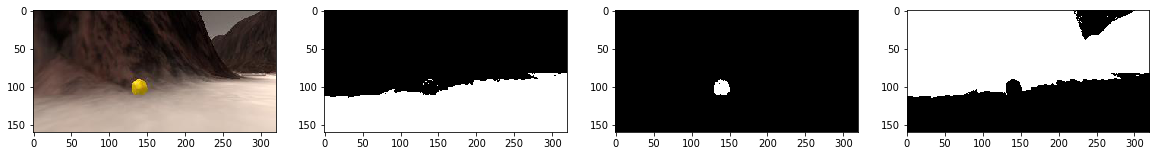

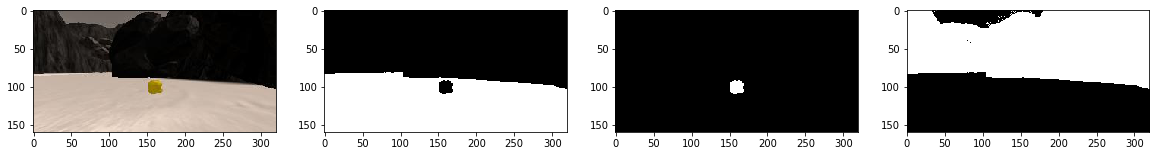

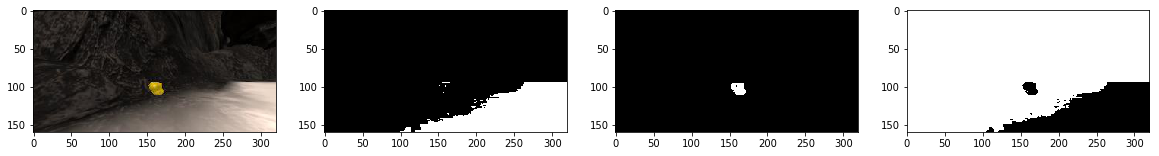

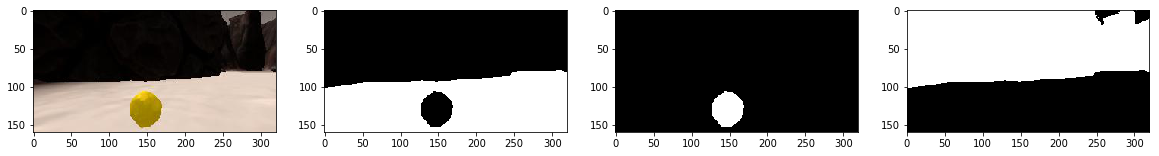

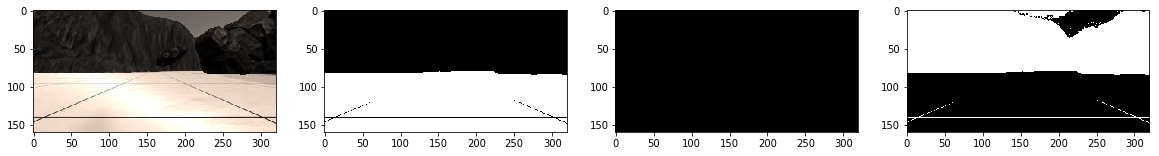

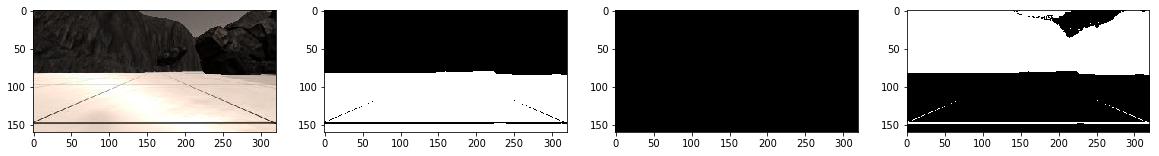

In [20]:
# Original image, navigable terrain, rock, obstacles

show_filtered_images(img)
show_filtered_images(rock1_img)
show_filtered_images(rock2_img)
show_filtered_images(img2)
show_filtered_images(grid1_img)
show_filtered_images(grid2_img)

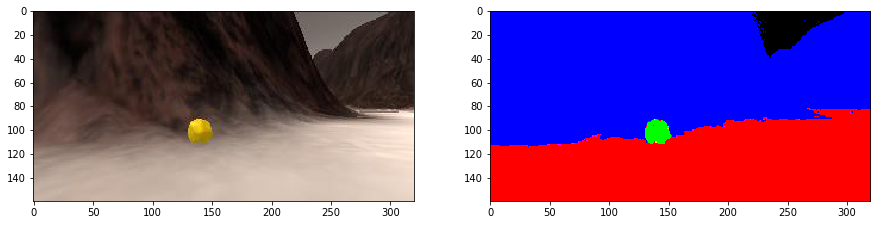

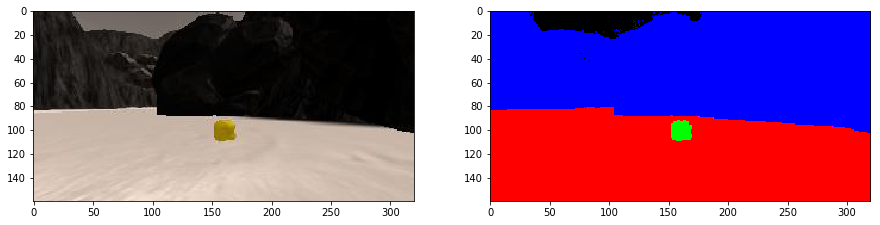

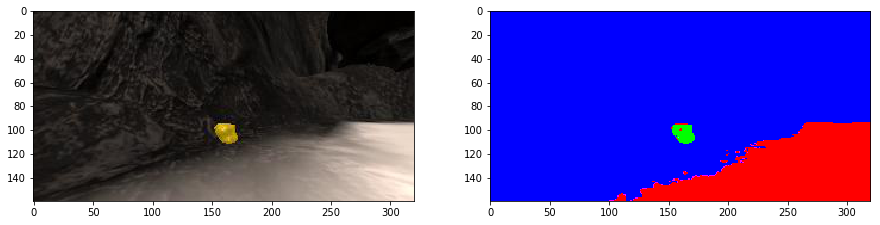

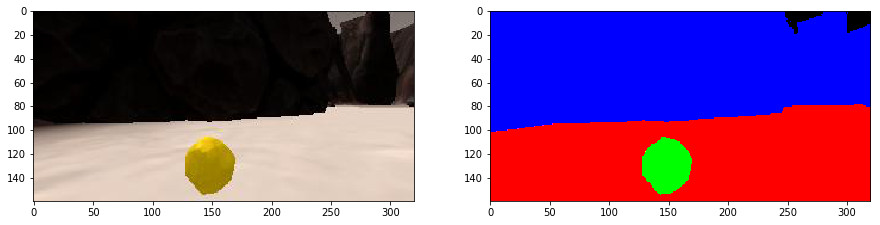

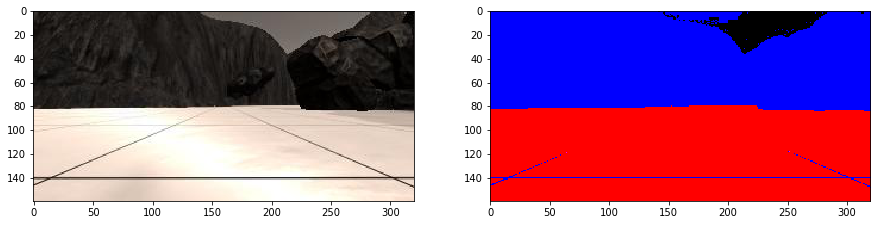

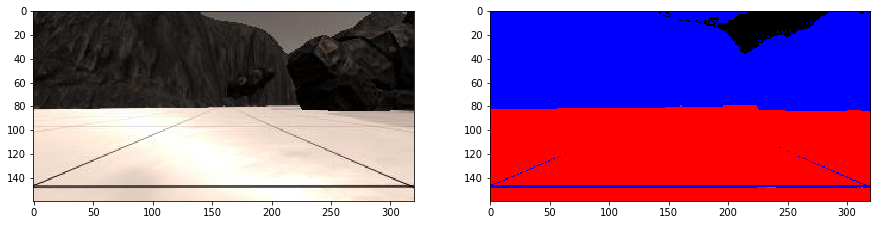

In [21]:
plot_two_images(img, get_coded_image(img))
plot_two_images(rock1_img, get_coded_image(rock1_img))
plot_two_images(rock2_img, get_coded_image(rock2_img))

plot_two_images(img2, get_coded_image(img2))
plot_two_images(grid1_img, get_coded_image(grid1_img))
plot_two_images(grid2_img, get_coded_image(grid2_img))

---
## FUNCTIONS: `get_rover_coordinates()` and `get_polar()`
---
- `get_rover_coordinates()`
- - A function that converts from image coordinates to rover coodinates from image
- - returns a list of x and y values 
- `convert_to_polar()`
- - A function to convert to polar coordinates from rover space
- - Convert all a list of x's and a list of y's to a list of distances and a list of angles

In [22]:
# A function that converts from image coordinates to rover coodinates from image
# returns a list of x and y values 
def get_rover_coordinates(binary_img):

  ys, xs = binary_img.nonzero()
  
  # Calculate positions with reference to the rover position being at the center bottom of the image.
  xs_rover = -(ys - binary_img.shape[0])
  ys_rover = -(xs - binary_img.shape[1] / 2 )
  #xs_rover = np.absolute(ys - binary_img.shape[0])
  #ys_rover = -(xs - binary_img.shape[0])

  return xs_rover, ys_rover

# A function to convert to polar coordinates from rover space
# Convert all a list of x's and a list of y's to a list of distances and a list of angles
def convert_to_polar(xs, ys):
    
  distances = np.sqrt(xs**2 + ys**2)
  angles = np.arctan2(ys, xs)
  return distances, angles

---
## TEST: `get_rover_coordinates()` 
---

In [23]:
# This function illustrates the steps to get the direction the rover will rotate to from a camera image

def perception_pipeline(img):

  ground_bin = filter_hls(img, ground_thresh_min, ground_thresh_max, height = 70)
  warped_bin = transform_perspective(ground_bin, source_points, destination_points)
  
  warped_coded_img = get_coded_image(transform_perspective(img, source_points, destination_points))
    
  xs, ys = get_rover_coordinates(warped_bin)
  distances, angles = convert_to_polar(xs, ys)
  mean_direction = np.mean(angles)

  fig = plt.figure(figsize = (20,4))
  
  plt.subplot(141)
  plt.imshow(img)
  
  plt.subplot(142)
  plt.imshow(ground_bin, cmap = 'gray')
  
  plt.subplot(143)
  plt.imshow(warped_coded_img)
  
  plt.subplot(144)

  plt.plot(xs, ys, '.')
  plt.ylim(-160, 160)
  plt.xlim(0, 160)
  
  arrow_length = 100
  x_arrow = arrow_length * np.cos(mean_direction)
  y_arrow = arrow_length * np.sin(mean_direction)

  plt.arrow(0, 0, x_arrow, y_arrow, color = 'red', zorder = 2, head_width = 10, width = 2)

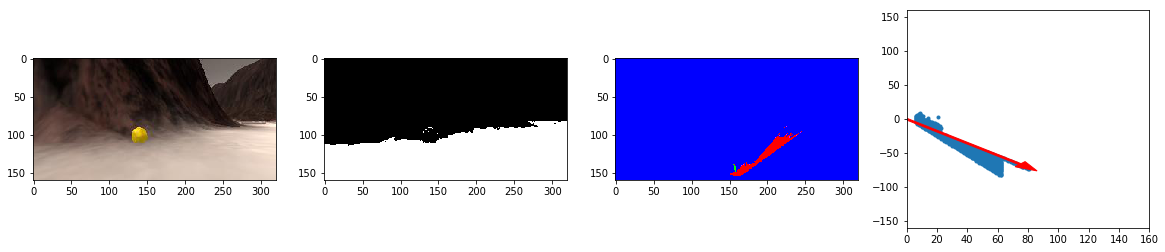

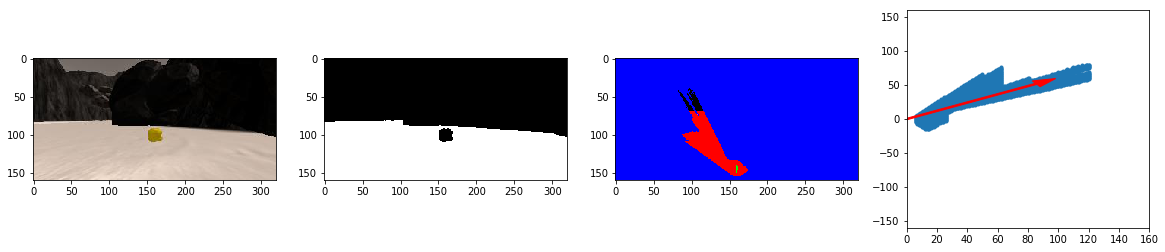

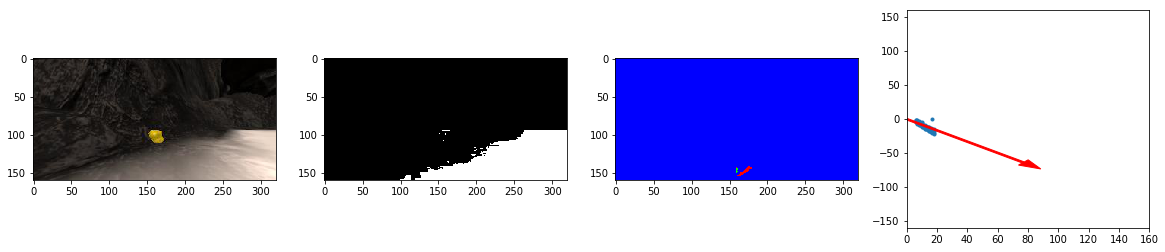

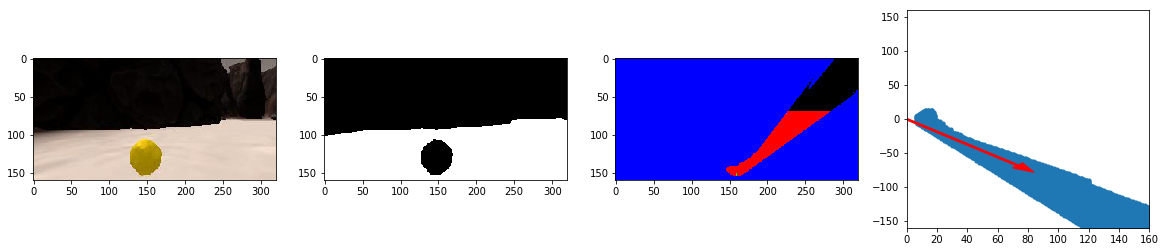

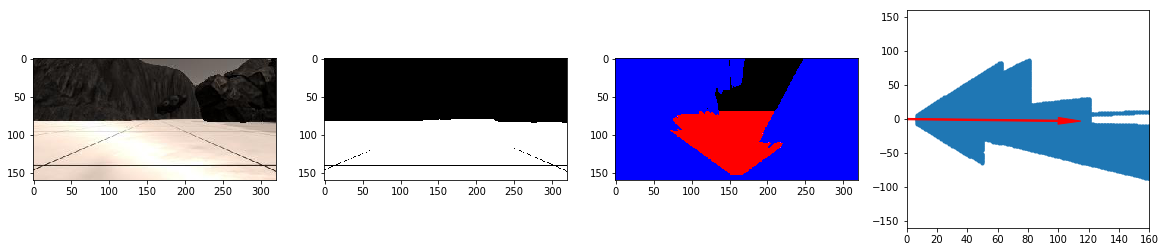

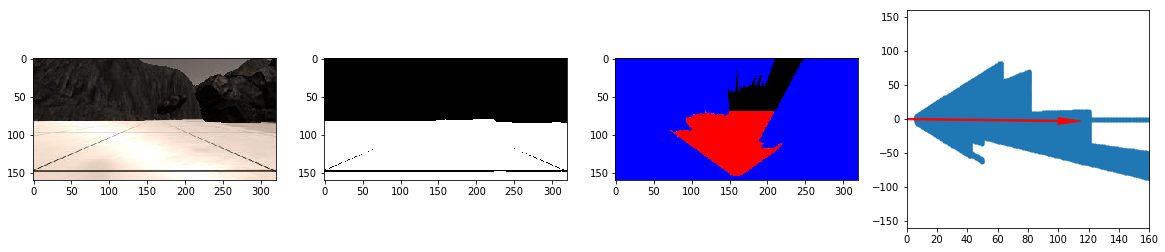

In [24]:
perception_pipeline(img)
perception_pipeline(rock1_img)
perception_pipeline(rock2_img)
perception_pipeline(img2)
perception_pipeline(grid1_img)
perception_pipeline(grid2_img)

---
## FUNCTION: `convert_rover_to_world_coordinates()`
---
- A function to apply rotation and translation (and clipping based on `world_size`)
- `xs`, `ys` are pixels in rover space
- `x_pos`, `y_pos` are the coordinates of the rover with respect to the world in world_map coordinates
- `yaw` is the orientation of the rover with respect to the world
- `scale` is the ratio of rover to world pixels


In [25]:
def convert_rover_to_world_coordinates(xs, ys, x_pos, y_pos, yaw, world_size, scale):

  # Convert yaw to radians
  a = yaw * np.pi / 180
  
  # rotate
  xs_rotated = (xs * np.cos(a)) - (ys * np.sin(a))                            
  ys_rotated = (xs * np.sin(a)) + (ys * np.cos(a))

  # scale and translate
  xs_world = xs_rotated / scale + x_pos
  ys_world = ys_rotated / scale + y_pos
  
  #clip
  xs_world = np.clip(np.int_(xs_world), 0, world_size - 1)
  ys_world = np.clip(np.int_(ys_world), 0, world_size - 1)

  return xs_world, ys_world


---
# TEST: `convert_rover_to_world_coordinates()`
---
- `mapping_pipeline`
- - This function illustrates the steps to from rover's camera image to map
- - color coded image 
- - warped color coded image
- - rover in world coordinates
- - rover super imposed with ground truth map


In [26]:
def mapping_pipeline(img, x_pos, y_pos, yaw):

  world_size, scale = WORLD_SIZE, 10

  # Get respective thresholded binary images
  ground_bin = filter_hls(img, ground_thresh_min, ground_thresh_max, height = 70)
  rock_bin = filter_hls(img, rock_thresh_min, rock_thresh_max)
  blocked_bin = filter_hls(img, blocked_thresh_min, blocked_thresh_max)

  # transform perspective of respective binary images
  warped_ground_bin = transform_perspective(ground_bin, source_points, destination_points)
  warped_rock_bin = transform_perspective(rock_bin, source_points, destination_points)
  warped_blocked_bin = transform_perspective(blocked_bin, source_points, destination_points)
    
  # Get respective thresholded pixels in rover coordinates
  ground_rover_xs, ground_rover_ys = get_rover_coordinates(warped_ground_bin)
  rock_rover_xs, rock_rover_ys = get_rover_coordinates(warped_rock_bin)
  blocked_rover_xs, blocked_rover_ys = get_rover_coordinates(warped_blocked_bin)
  
  # Get respective pixels in world coordinates

  gxs, gys = convert_rover_to_world_coordinates(ground_rover_xs, ground_rover_ys, x_pos, y_pos, yaw, world_size, scale)
  rxs, rys = convert_rover_to_world_coordinates(rock_rover_xs, rock_rover_ys, x_pos, y_pos, yaw, world_size, scale)
  bxs, bys = convert_rover_to_world_coordinates(blocked_rover_xs, blocked_rover_ys, x_pos, y_pos, yaw, world_size, scale)
  
  # Build the a world map from ground truth
  world_ys, world_xs = ground_truth_bin.nonzero()
  map_img = np.zeros((200, 200, 3))
  map_img[world_ys, world_xs, :] = (1, 1, 1)

  # Display pixels in world coordinate 
  with_rover_img = np.zeros((200, 200, 3))
  with_rover_img[gys, gxs, 0] = 1
  with_rover_img[rys, rxs, 1] = 1
  with_rover_img[bys, bxs, 2] = 1

  # Super impose ground truth and pixels in world coordinate
  map_with_rover_img = cv2.addWeighted(map_img, 0.3, with_rover_img, 1, 0)
  
  coded_img = get_coded_image(img)
  warped_coded_img = transform_perspective(coded_img, source_points, destination_points)

  fig = plt.figure(figsize = (20,4))
  
  plt.subplot(151)
  plt.imshow(coded_img)
  
  plt.subplot(152)
  plt.imshow(warped_coded_img)

  plt.subplot(153)
  plt.plot(blocked_rover_xs, blocked_rover_ys, '.')
  plt.plot(ground_rover_xs, ground_rover_ys, '.')

  plt.ylim(-160, 160)
  plt.xlim(0, 160)

  plt.subplot(154)
  plt.imshow(with_rover_img)
    
  plt.subplot(155)
  plt.imshow(map_with_rover_img)
 

(160, 320, 3) (160, 320, 3)


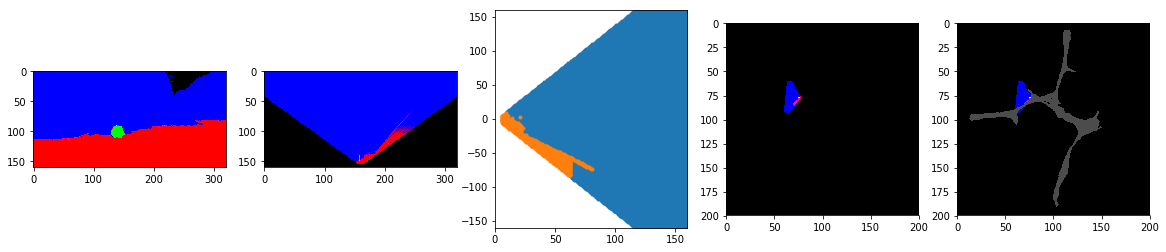

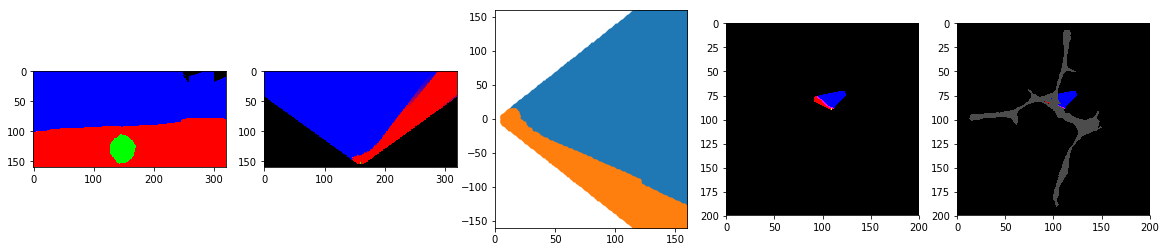

In [27]:
print(img.shape, img2.shape)
mapping_pipeline(img, data_xs[3572], data_ys[3572], data_yaws[3572])
mapping_pipeline(img2, data_xs[i], data_ys[i], data_yaws[i])

---
# `Databucket` object
---


In [28]:
# Will read in saved data from csv file and populate this object

class Databucket():
  def __init__(self, data_xs, data_ys, data_yaws, data_img_paths, ground_truth_img):
  
    self.images = data_img_paths
    self.xs = data_xs
    self.ys = data_ys
    self.yaws = data_yaws
    self.ground_truth = ground_truth_img
    self.map = ground_truth_img * 0
  
    self.count = -1 
    # This will be a running index, setting to -1 is a hack,
    # because moviepy (below) seems to run one extra iteration


---
# FUNCTION: `process_image()`
---


In [29]:
def process_image(img):
    
  world_size, scale = WORLD_SIZE, SCALE
  x_pos, y_pos, yaw = data.xs[data.count], data.ys[data.count], data.yaws[data.count]
  
  # Get respective thresholded binary images
  ground_bin = filter_hls(img, ground_thresh_min, ground_thresh_max, height = 70)
  rock_bin = filter_hls(img, rock_thresh_min, rock_thresh_max)
  blocked_bin = filter_hls(img, blocked_thresh_min, blocked_thresh_max)

  # transform perspective of respective binary images
  warped_ground_bin = transform_perspective(ground_bin, source_points, destination_points)
  warped_rock_bin = transform_perspective(rock_bin, source_points, destination_points)
  warped_blocked_bin = transform_perspective(blocked_bin, source_points, destination_points)
    
  # Get respective thresholded pixels in rover coordinates
  ground_rover_xs, ground_rover_ys = get_rover_coordinates(warped_ground_bin)
  rock_rover_xs, rock_rover_ys = get_rover_coordinates(warped_rock_bin)
  blocked_rover_xs, blocked_rover_ys = get_rover_coordinates(warped_blocked_bin)
  
  # Get respective pixels in world coordinates
  gxs, gys = convert_rover_to_world_coordinates(ground_rover_xs, ground_rover_ys, x_pos, y_pos, yaw, world_size, scale)
  rxs, rys = convert_rover_to_world_coordinates(rock_rover_xs, rock_rover_ys, x_pos, y_pos, yaw, world_size, scale)
  bxs, bys = convert_rover_to_world_coordinates(blocked_rover_xs, blocked_rover_ys, x_pos, y_pos, yaw, world_size, scale)

  # Add current coordinates to map 
  data.map[gys, gxs, 0] = 255
  data.map[rys, rxs, 1] = 255
  data.map[bys, bxs, 2] = 255

  snapshot = np.zeros((200, 200, 3))
  snapshot[gys, gxs, 0] = 255
  snapshot[rys, rxs, 1] = 255
  snapshot[bys, bxs, 2] = 255

  # Superimpose ground truth and map we've built
  superimposed_map = cv2.addWeighted(data.map, 0.75, data.ground_truth, 0.4, 0)
  
  # Superimpose ground truth and snapshot
  superimposed_snapshot = cv2.addWeighted(snapshot, 1.0, data.ground_truth, 0.15, 0)
    
  # Get color coded images to be displayed later
  coded_img = get_coded_image(img)
  warped_coded_img = transform_perspective(coded_img, source_points, destination_points)   

  img_y, img_x = 160, 320
  map_y, map_x = 200, 200

  output_img = np.zeros((360, 960, 3))
    
  output_img[200:360, 0:320] = img
  output_img[200:360, 320:640] = coded_img
  output_img[200:360, 640:960] = warped_coded_img

  # Flip map overlay so y-axis points upward and add to output_image 
  output_img[0:200, 0:200] =  np.flipud(data.ground_truth)
  output_img[0:200, 200:400] = np.flipud(data.map)
  output_img[0:200, 400:600] =  np.flipud(superimposed_map)
  output_img[0:200:, 600:800] = np.flipud(superimposed_snapshot)

  data.count+=1

  return output_img

---
# Create a video
---
Use the [moviepy](https://zulko.github.io/moviepy/) library to process images and create a video.
  

In [30]:
###
# Make a global data_object to be used by the process_image_function
###

df = pd.read_csv('../dataset/robot_log.csv', delimiter=';', decimal='.')
data_img_paths = df["Path"].tolist() # list of image pathnames

data_xs = df["X_Position"].values
data_ys = df["Y_Position"].values
data_yaws = df["Yaw"].values

ground_truth_bin = mpimg.imread('../calibration_images/map_bw.png')

ground_truth_ys, ground_truth_xs = ground_truth_bin.nonzero()
ground_truth_img = np.zeros((200, 200, 3))
ground_truth_img[ground_truth_ys, ground_truth_xs, :] = (0, 255, 0) 

data = Databucket(data_xs, data_ys, data_yaws, data_img_paths, ground_truth_img)

In [31]:
# Note: output video will be sped up because recording rate in simulator is fps=25
clip = ImageSequenceClip(data.images, fps = 60) 

#NOTE: this function expects color images!!
new_clip = clip.fl_image(process_image) 

%time new_clip.write_videofile(output_path, audio = False)


[MoviePy] >>>> Building video ../output/test_mapping.mp4
[MoviePy] Writing video ../output/test_mapping.mp4


100%|██████████| 4191/4191 [01:52<00:00, 37.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output/test_mapping.mp4 

CPU times: user 1min 36s, sys: 12.1 s, total: 1min 48s
Wall time: 1min 53s


---
# Play Video Inline
---

In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_path))

---

# An alternative way to play  a video
---

In [33]:
import io
import base64
video = io.open(output_path, 'r+b').read()
encoded_video = base64.b64encode(video)
HTML(data = '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded_video.decode('ascii')))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.
